<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-CatBoost" data-toc-modified-id="Модель-CatBoost-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Модель CatBoost</a></span></li><li><span><a href="#Модель-Logistic-Regression" data-toc-modified-id="Модель-Logistic-Regression-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Модель Logistic Regression</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 


## Подготовка

In [1]:
!pip install -U nltk
!python -m nltk.downloader popular
!pip install -U pywsd

     |████████████████████████████████| 1.5 MB 2.2 MB/s eta 0:00:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.6.1
    Uninstalling nltk-3.6.1:
      Successfully uninstalled nltk-3.6.1
/opt/conda/lib/python3.9/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/jovyan/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package guten

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [3]:
data = pd.read_csv('/datasets/toxic_comments.csv')
data

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


Датасет содержит 159292 строк и 3 столбца. Удалим столбец `Unnamed: 0`.

In [4]:
data.drop(columns='Unnamed: 0', inplace=True)

Посмотрим распределение текстов.

0    143106
1     16186
Name: toxic, dtype: int64


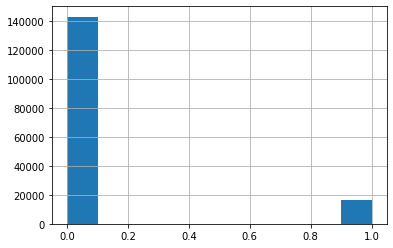

In [5]:
data['toxic'].hist()
print(data.toxic.value_counts())

В данных присутствует сильный дисбаланс, токсичных комментариев почти в 10 раз меньше. Учтем это при создании моделей.

Лемматизируем текст, приведем к нижнему регистру и уберем все лишнее.

In [6]:
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatize_sent(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text) 
    return ' '.join([wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))])

data['lemm_text'] = data['text'].apply(lemmatize_sent)

data = data.drop(['text'], axis=1)

Уберем ненужные слова.

In [7]:
nltk.download('stopwords')
stopwords = list(nltk_stopwords.words('english'))

tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Выделим целевой и обучающий признак.

In [8]:
target = data['toxic']
features = data.drop(columns='toxic', axis=1)

Разделим данные на обучающую, валидационную и тестовую выборки. Добавляем параметр `stratify`, чтобы правильно разделить выборки с учетом дисбаланса.

In [9]:
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=75,
                                                                            test_size=0.2, stratify=target)

features_train = tf_idf.fit_transform(features_train['lemm_text'])
features_test = tf_idf.transform(features_test['lemm_text'])

In [10]:
features_train

<127433x136605 sparse matrix of type '<class 'numpy.float64'>'
	with 3346818 stored elements in Compressed Sparse Row format>

## Обучение

### Модель CatBoost

In [10]:
skf = StratifiedKFold(n_splits=3, random_state=75, shuffle=True)

boost_model = CatBoostClassifier(
    iterations=300,
    random_seed=75,
    learning_rate=0.4
)

print(cross_val_score(boost_model, features_train, target_train, cv=skf, scoring='f1').mean())

0:	learn: 0.3907035	total: 2s	remaining: 9m 59s
1:	learn: 0.2895876	total: 3.52s	remaining: 8m 43s
2:	learn: 0.2517631	total: 5.07s	remaining: 8m 21s
3:	learn: 0.2357529	total: 6.59s	remaining: 8m 7s
4:	learn: 0.2223615	total: 8.19s	remaining: 8m 3s
5:	learn: 0.2153654	total: 9.7s	remaining: 7m 55s
6:	learn: 0.2092079	total: 11.2s	remaining: 7m 49s
7:	learn: 0.2042203	total: 12.7s	remaining: 7m 42s
8:	learn: 0.2006969	total: 14.2s	remaining: 7m 39s
9:	learn: 0.1970061	total: 15.7s	remaining: 7m 34s
10:	learn: 0.1940012	total: 17.3s	remaining: 7m 33s
11:	learn: 0.1908490	total: 18.8s	remaining: 7m 30s
12:	learn: 0.1883484	total: 20.3s	remaining: 7m 27s
13:	learn: 0.1851067	total: 21.7s	remaining: 7m 23s
14:	learn: 0.1829602	total: 23.3s	remaining: 7m 23s
15:	learn: 0.1806862	total: 24.9s	remaining: 7m 22s
16:	learn: 0.1792759	total: 26.3s	remaining: 7m 18s
17:	learn: 0.1768874	total: 28s	remaining: 7m 18s
18:	learn: 0.1755518	total: 29.4s	remaining: 7m 15s
19:	learn: 0.1738473	total: 30

Метрика F1 модели Catboost на кросс-валидации составила 74.4%.

### Модель Logistic Regression

In [11]:
logistic_model = LogisticRegression(random_state=75, class_weight = 'balanced', max_iter=1000)
print(cross_val_score(logistic_model, features_train, target_train, cv=skf, scoring = 'f1').mean())

0.7424120066346244


Метрика F1 модели Logistic Regression составила 74.2%.

## Выводы

Проверим модель CatBoost на тестовых данных.

In [12]:
boost_model = CatBoostClassifier(
    iterations=300,
    random_seed=75,
    learning_rate=0.4
)
boost_model.fit(features_train, target_train)
print('Метрика F1 на тесте:', f1_score(target_test, boost_model.predict(features_test)))

0:	learn: 0.3816254	total: 2.75s	remaining: 13m 42s
1:	learn: 0.2790625	total: 4.89s	remaining: 12m 8s
2:	learn: 0.2463390	total: 7.06s	remaining: 11m 39s
3:	learn: 0.2297594	total: 9.14s	remaining: 11m 16s
4:	learn: 0.2177816	total: 11.2s	remaining: 11m 1s
5:	learn: 0.2110472	total: 13.2s	remaining: 10m 48s
6:	learn: 0.2063301	total: 15.4s	remaining: 10m 43s
7:	learn: 0.2021710	total: 17.5s	remaining: 10m 39s
8:	learn: 0.1974736	total: 19.8s	remaining: 10m 40s
9:	learn: 0.1940783	total: 22s	remaining: 10m 37s
10:	learn: 0.1910719	total: 24.2s	remaining: 10m 36s
11:	learn: 0.1886190	total: 26.4s	remaining: 10m 34s
12:	learn: 0.1850671	total: 28.7s	remaining: 10m 32s
13:	learn: 0.1819709	total: 30.6s	remaining: 10m 25s
14:	learn: 0.1801730	total: 32.7s	remaining: 10m 20s
15:	learn: 0.1784419	total: 34.7s	remaining: 10m 15s
16:	learn: 0.1758773	total: 36.8s	remaining: 10m 11s
17:	learn: 0.1744690	total: 38.8s	remaining: 10m 7s
18:	learn: 0.1728430	total: 40.7s	remaining: 10m 1s
19:	learn

Получилось, что модель градиентного бустинга показывает результат 75.8%, ее параметры можно улучшить, используя поиск по сетке или optuna, но в данный момент результат достигнут с метрикой F1 больше 75.